In [1]:
from utilities import utils
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy import stats
import arviz as az
import torch
import pyro
import pyro.distributions as dist
from pyro.distributions import constraints
from pyro.infer import Predictive, TracePredictive, NUTS, MCMC
from pyro.infer.autoguide import AutoLaplaceApproximation
from pyro.infer import SVI, Trace_ELBO
from pyro.optim import Adam
from pyro.infer.mcmc.util import summary
import os
plt.style.use('ggplot')

/Users/wastechs/opt/anaconda3/envs/probs/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Chapter 4 - Extending Linear Models

In [ ]:
babies = pd.read_csv(os.path.abspath('.') + '/data/babies.csv')
babies

## 4.1 Transforming Covariates

### Figure 4.2

In [ ]:
X_ = torch.from_numpy(babies['Month'].values.reshape(-1, 1))
X_ = torch.tensor(X_).float()

y = torch.from_numpy(babies['Length'].values)
y = torch.tensor(y).float()

In [ ]:
def linear_babies(month, length=None):

    N, P = month.shape
    
    beta_0 = pyro.sample('beta_0', dist.Normal(0., 10.))
    beta_1 = pyro.sample('beta_1', dist.Normal(0, 10.).expand([P]))
    sigma = pyro.sample('sigma', dist.HalfNormal(10.))
    mu = beta_0 + torch.matmul(beta_1, month.T)
    
    with pyro.plate('plate', size=N):
        y = pyro.sample('y', dist.Normal(mu, sigma), obs=length)

In [ ]:
pyro.render_model(
    linear_babies, 
    model_args=(X_, y),
    render_distributions=True
    )

In [ ]:
kernel = NUTS(linear_babies, adapt_step_size=True)
mcmc_linear_babies = MCMC(kernel, 500, 300)
mcmc_linear_babies.run(X_, y)

In [ ]:
mcmc_babie_samples = mcmc_linear_babies.get_samples(1000)
predictive = Predictive(linear_babies, mcmc_babie_samples)(X_, None)

az_linear_babies = az.from_pyro(
    posterior=mcmc_linear_babies, posterior_predictive=predictive)

In [ ]:
y_mu = predictive['y'].mean(axis=0)

In [ ]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x=babies['Month'], y=babies['Length'], color='grey', alpha=0.75)
sns.lineplot(x=babies['Month'], y=y_mu, color='blue')
az.plot_hdi(x=babies['Month'], y=predictive['y'].numpy())
plt.show()

### Figure 4.3

In [ ]:
def sqrt_babies(month, length=None):

    N, P = month.shape
    
    beta_0 = pyro.sample('beta_0', dist.Normal(0., 10.))
    beta_1 = pyro.sample('beta_1', dist.Normal(0, 10.).expand([P]))
    sigma = pyro.sample('sigma', dist.HalfNormal(10.))
    mu = beta_0 + torch.matmul(beta_1, torch.sqrt(month.T))
    
    with pyro.plate('plate', size=N):
        y = pyro.sample('y', dist.Normal(mu, sigma), obs=length)

In [ ]:
kernel = NUTS(sqrt_babies, adapt_step_size=True)
mcmc_sqrt = MCMC(kernel, 500, 300)
mcmc_sqrt.run(X_, y)

In [ ]:
mcmc_sqrt_babie_samples = mcmc_sqrt.get_samples(1000)
predictive_sqrt = Predictive(sqrt_babies, mcmc_sqrt_babie_samples)(X_, None)

az_sqrt_babies = az.from_pyro(
    posterior=mcmc_sqrt, posterior_predictive=predictive_sqrt)

In [ ]:
y_mu = predictive_sqrt['y'].mean(axis=0)

In [ ]:
plt.figure(figsize=(10, 6))
plt.scatter(babies['Month'], babies['Length'], c='black', alpha=0.5)
plt.plot(babies['Month'], y_mu, color='blue')
az.plot_hdi(x=babies['Month'], y=az_sqrt_babies['posterior_predictive']['y'], hdi_prob=.50, color='grey')
az.plot_hdi(x=babies['Month'], y=az_sqrt_babies['posterior_predictive']['y'], hdi_prob=.94, color='darkgrey')
plt.title('Linear model with square root transformation on months')
plt.show()

## 4.2 - Varying Uncertainty

## 4.3 - Interaction Effects

In [ ]:
tips_df = pd.read_csv(os.path.abspath('.') + '/data/tips.csv')
tips_df

In [ ]:
total_bill_centered = torch.tensor((tips_df["total_bill"] - tips_df["total_bill"].mean()).values, dtype=torch.float64)
tips = torch.tensor(tips_df["tip"].values, dtype=torch.float64)
smoker = torch.tensor(pd.Categorical(tips_df["smoker"]).codes, dtype=torch.float64)

In [ ]:
def interaction_model(bill, smoker, tips=None):
    
    #N, P = 

    beta = pyro.sample('beta', dist.Normal(0., 1.).expand([4]))
    sigma = pyro.sample('sigma', dist.HalfNormal(1.))
    mu = beta[0] + beta[1] * bill + beta[2] * smoker + beta[3] * smoker * bill

    with pyro.plate('plate', len(bill)):
        y = pyro.sample('y', dist.Normal(mu, sigma), obs=tips)

In [ ]:
pyro.render_model(
    interaction_model,
    (total_bill_centered, smoker, tips), render_distributions=True)

In [ ]:
kernel = NUTS(interaction_model, adapt_step_size=True)
mcmc_interaction = MCMC(kernel, 500, 300)
mcmc_interaction.run(total_bill_centered, smoker, tips)

In [ ]:
mcmc_interaction_samples = mcmc_interaction.get_samples(1000)
interaction_predictive = Predictive(interaction_model, mcmc_interaction_samples)
posterior_predictive = interaction_predictive(total_bill_centered, smoker, None)

az_inference_interaction = az.from_pyro(
    posterior=mcmc_interaction, posterior_predictive=posterior_predictive)

In [ ]:
tip_mu = posterior_predictive['y'].mean(axis=0)
tip_std = posterior_predictive['y'].std(axis=0)

predictions = pd.DataFrame({
    'bill': total_bill_centered,
    'smoker': smoker,
    'tip': tips, 
    'tip_mu': tip_mu,
    'tip_std': tip_std,
    'tip_high': tip_mu + tip_std,
    'tip_low': tip_mu - tip_std
})

predictions = predictions.sort_values(by=['bill'])

In [ ]:
smoker_df = predictions[predictions['smoker'] == 1]
nonsmoker_df = predictions[predictions['smoker'] == 0]

In [ ]:
# colors are terrible - TO DO
plt.figure(figsize=(10, 6))
sns.lineplot(x=smoker_df['bill'], y=smoker_df['tip_mu'], color='blue')
plt.fill_between(smoker_df['bill'], smoker_df['tip_low'], smoker_df['tip_high'], color='lightblue')
sns.lineplot(x=nonsmoker_df['bill'], y=nonsmoker_df['tip_mu'], color='red')
plt.fill_between(nonsmoker_df['bill'], nonsmoker_df['tip_low'], nonsmoker_df['tip_high'], color='lightgrey')
sns.scatterplot(x=predictions['bill'], y=predictions['tip'], hue=predictions['smoker'])
plt.legend(['smoker', 'non-smoker'])
plt.title('Interaction Effect on Tip')
plt.show()

## 4.4 - Robust Regression

In [ ]:
def generate_sales(*, days, mean, std, label):
    """code taken from the authors / book"""
    np.random.seed(0)
    df = pd.DataFrame(index=range(1, days+1), columns=["customers", "sales"])
    for day in range(1, days+1):
        num_customers = stats.randint(30, 100).rvs()+1
        
        # This is correct as there is an independent draw for each customers orders
        dollar_sales = stats.norm(mean, std).rvs(num_customers).sum()
        
        df.loc[day, "customers"] = num_customers
        df.loc[day, "sales"] = dollar_sales
        
    # Fix the types as not to cause Theano errors
    df = df.astype({'customers': 'int32', 'sales': 'float32'})
    
    # Sorting will make plotting the posterior predictive easier later
    df["Food_Category"] = label
    df = df.sort_values("customers")
    
    return df

In [ ]:
empanadas = generate_sales(days=200, mean=180, std=30, label="Empanada")

empanadas.iloc[0] = [50, 92000, "Empanada"]
empanadas.iloc[1] = [60, 90000, "Empanada"]
empanadas.iloc[2] = [70, 96000, "Empanada"]
empanadas.iloc[3] = [80, 91000, "Empanada"]
empanadas.iloc[4] = [90, 99000, "Empanada"]

empanadas = empanadas.sort_values("customers")

fig, ax = plt.subplots(figsize=(10, 6))
empanadas.sort_values("sales")[:-5].plot(x="customers", y="sales", kind="scatter", ax=ax);
empanadas.sort_values("sales")[-5:].plot(x="customers", y="sales", kind="scatter", c="black", ax=ax);

ax.set_ylabel("Argentine Peso")
ax.set_xlabel("Customer Count")
ax.set_title("Empanada Sales")

In [ ]:
customer_count = torch.tensor(empanadas['customers'].values, dtype=torch.float64)
sales = torch.tensor(empanadas['sales'].values, dtype=torch.float64)

In [ ]:
def robust_regression(customers, peso=None):

    sigma = pyro.sample('sigma', dist.HalfNormal(50.))
    beta = pyro.sample('beta', dist.Normal(150., 20.))
    v = pyro.sample('dof', dist.HalfNormal(20.))

    mu = pyro.deterministic('mu', beta * customers)

    with pyro.plate('plate', len(customers)):
        sales = pyro.sample('sales', dist.StudentT(loc=mu, scale=sigma, df=v), obs=peso)

In [ ]:
pyro.render_model(
    robust_regression, (customer_count, sales), render_distributions=True)

In [ ]:
kernel = NUTS(robust_regression)
mcmc_robust = MCMC(kernel, 500, 300)
mcmc_robust.run(customer_count, sales)

In [ ]:
mcmc_robust.summary()

In [ ]:
mcmc_robust_samples = mcmc_robust.get_samples(1000)
robust_predictive = Predictive(robust_regression, mcmc_robust_samples)(customer_count, None)
az_robust_inf = az.from_pyro(posterior=mcmc_robust, posterior_predictive=robust_predictive)

In [ ]:
mu = az_robust_inf['posterior_predictive']['mu'].values.reshape(-1, len(customer_count)).mean(axis=0)

plt.figure(figsize=(10, 6))
plt.scatter(customer_count, sales)
plt.plot(customer_count, mu, c='blue')
az.plot_hdi(customer_count, az_robust_inf['posterior_predictive']['sales'], color='grey')
plt.xlabel('Customer Count')
plt.ylabel('Sales')
plt.title('Robust Regression using Student-t likelihood')
plt.show()

## 4.5 - Pooling, Multilevel Models, Mixed Effects

In [2]:
def generate_sales(*, days, mean, std, label):
    """code taken from authors / book"""
    np.random.seed(0)
    df = pd.DataFrame(index=range(1, days+1), columns=["customers", "sales"])
    for day in range(1, days+1):
        num_customers = stats.randint(30, 100).rvs()+1
        
        # This is correct as there is an independent draw for each customers orders
        dollar_sales = stats.norm(mean, std).rvs(num_customers).sum()
        
        df.loc[day, "customers"] = num_customers
        df.loc[day, "sales"] = dollar_sales
        
    # Fix the types as not to cause Theano errors
    df = df.astype({'customers': 'int32', 'sales': 'float32'})
    
    # Sorting will make plotting the posterior predictive easier later
    df["Food_Category"] = label
    df = df.sort_values("customers")
    
    return df

In [3]:
pizza_df = generate_sales(days=365, mean=13, std=5, label="Pizza")
sandwich_df = generate_sales(days=100, mean=6, std=5, label="Sandwich")
salad_days = 3
salad_df = generate_sales(days=salad_days, mean=8 ,std=3, label="Salad")

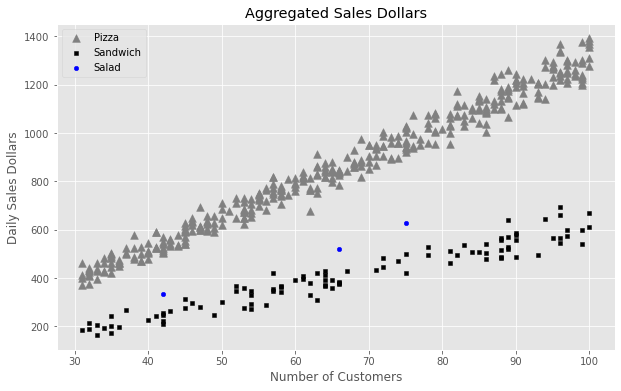

In [4]:
fig, ax = plt.subplots(figsize=(10, 6))
pizza_df.plot(x="customers", y="sales", kind="scatter", ax=ax, c="grey", label="Pizza", marker="^", s=60);
sandwich_df.plot(x="customers", y="sales", kind="scatter", ax=ax, c='black', label="Sandwich", marker="s");
salad_df.plot(x="customers", y="sales", kind="scatter", ax=ax, label="Salad", c="blue");

ax.set_xlabel("Number of Customers")
ax.set_ylabel("Daily Sales Dollars")
ax.set_title("Aggregated Sales Dollars")
ax.legend()
plt.show()

In [5]:
sales_df = pd.concat([pizza_df, sandwich_df, salad_df]).reset_index(drop=True)
sales_df["Food_Category"] = pd.Categorical(sales_df["Food_Category"])
sales_df

,customers,sales,Food_Category
0,31,459.895203,Pizza
1,31,401.147736,Pizza
2,31,413.345245,Pizza
3,31,371.909241,Pizza
4,32,433.797089,Pizza
...,...,...,...
463,100,611.736816,Sandwich
464,100,667.152954,Sandwich
465,42,331.625702,Salad
466,66,520.900940,Salad


In [6]:
customers = torch.tensor(sales_df['customers'].values, dtype=torch.float64)
sales = torch.tensor(sales_df['sales'].values, dtype=torch.float64)
food_category = torch.tensor(sales_df['Food_Category'].cat.codes.values, dtype=torch.long)

**Notes:**

- extend shape to 3 because of the 3 food categories
- use `dtype = torch.long` when using a tensor as indices
- if you use the `pyro.plate()` primitive, it seems you do not need to specify the `.expand()` method on distributions, i.e., to make the batch size > 1 in the case of a multidimensional design matrix

### Unpooled - MCMC

In [ ]:
def unpooled_model(food_cat, customers, sales=None):

    P = 3
    N = len(customers)

    with pyro.plate('food_cat_i', len(np.unique(food_cat))):
        sigma = pyro.sample('sigma', dist.HalfNormal(20.))
        beta = pyro.sample('beta', dist.Normal(10., 10.))
    
    with pyro.plate('data', N):
        mu = pyro.deterministic('mu', beta[food_cat] * customers)
        output = pyro.sample('y', dist.Normal(mu, sigma[food_cat]), obs=sales)

In [ ]:
# should be: beta -> mu -> y
pyro.render_model(
    unpooled_model, (food_category, customers, sales),
    render_distributions=True
)

In [ ]:
kernel = NUTS(unpooled_model)
mcmc_unpooled = MCMC(kernel, 500, 300)
mcmc_unpooled.run(food_category, customers, sales)

In [ ]:
mcmc_unpooled.summary()

In [ ]:
unpooled_posterior_samples = mcmc_unpooled.get_samples(1000)
unpooled_predictive = \
    Predictive(unpooled_model, unpooled_posterior_samples)(food_category, customers, None)

az_unpooled_inf = az.from_pyro(
    posterior=mcmc_unpooled, posterior_predictive=unpooled_predictive)

In [ ]:
az.plot_trace(az_unpooled_inf, var_names=["beta", "sigma"], compact=False)
plt.tight_layout()

In [ ]:
az.plot_forest(az_unpooled_inf, var_names=['beta'])
plt.show()

In [ ]:
az.plot_forest(az_unpooled_inf, var_names=['sigma'])
plt.show()

### Unpooled - SVI

In [ ]:
customers_z = (customers - torch.mean(customers)) / (torch.std(customers))
sales_z = (sales - torch.mean(sales)) / (torch.std(sales))

In [ ]:
customers_z.min(), customers_z.max()

In [ ]:
sales_z.min(), sales_z.max()

In [ ]:
def unpooled_model(food_cat, customers, sales=None):

    P = 3
    N = len(customers)

    with pyro.plate('food_cat_i', len(np.unique(food_cat))):
        sigma = pyro.sample('sigma', dist.HalfNormal(20.))
        beta = pyro.sample('beta', dist.Normal(10., 10.))
    
    with pyro.plate('data', N):
        mu = pyro.deterministic('mu', beta[food_cat] * customers)
        output = pyro.sample('y', dist.Normal(mu, sigma[food_cat]), obs=sales)

In [ ]:
def unpooled_guide(food_cat, customers, sales=None): 

    with pyro.plate('food_cat_i', len(np.unique(food_cat))):
        sigma_scale = pyro.param(
            'sigma_scale', torch.tensor(1.), constraint=constraints.positive
            )
        sigma = pyro.sample('sigma', dist.HalfNormal(sigma_scale))

        beta_loc = pyro.param('beta_loc', torch.tensor(10.))
        beta_scale = pyro.param(
            'beta_scale', torch.tensor(1.), constraint=constraints.positive)
        beta = pyro.sample('beta', dist.Normal(beta_loc, beta_scale))

In [ ]:
pyro.render_model(
    unpooled_guide, (food_category, customers, sales), render_params=True)

In [ ]:
pyro.clear_param_store()

#adam_params = {'lr': 0.005, 'betas': (0.95, 0.99)}
adam_params = {'lr': 0.005}
optim = Adam(adam_params)
svi = SVI(unpooled_model, unpooled_guide, optim, Trace_ELBO())

iter = 1000
elbo_loss = []
for i in range(iter):
    loss = svi.step(food_category, customers_z, sales_z)
    elbo_loss.append(loss)

plt.figure(figsize=(10, 3))
plt.plot(np.arange(1, iter+1), elbo_loss)
plt.ylabel('ELBO Loss')
plt.xlabel('Iterations')
plt.title(f'iter {len(elbo_loss)}, loss: {elbo_loss[-1]:.4f}')
plt.show()

In [ ]:
for name, value in pyro.get_param_store().items():
    print(name, pyro.param(name).data.cpu().numpy())

In [ ]:
predictive = Predictive(unpooled_model, guide=unpooled_guide, num_samples=1000)
posterior_svi_samples = predictive(food_category, customers, None)

In [ ]:
sigma, beta = utils.summary(posterior_svi_samples)['sigma'], \
    utils.summary(posterior_svi_samples)['beta']

In [ ]:
beta

In [ ]:
sigma

### Pooled - MCMC

In [7]:
def pooled_model(food_cat, customers, sales=None):

    P = 3
    N = len(customers)

    sigma = pyro.sample('sigma', dist.HalfNormal(20.))
    beta = pyro.sample('beta', dist.Normal(10., 10.))
    
    with pyro.plate('data', N):
        mu = pyro.deterministic('mu', beta * customers)
        output = pyro.sample('y', dist.Normal(mu, sigma), obs=sales)

In [8]:
kernel = NUTS(pooled_model)
mcmc_pooled = MCMC(kernel, 500, 300)
mcmc_pooled.run(food_category, customers, sales)

Sample: 100%|██████████| 800/800 [00:05, 143.41it/s, step size=9.98e-01, acc. prob=0.917]


In [9]:
mcmc_pooled.summary()


                mean       std    median      5.0%     95.0%     n_eff     r_hat
      beta     11.50      0.12     11.49     11.29     11.70    436.12      1.00
     sigma    186.18      4.97    186.01    177.77    193.65    294.25      1.00

Number of divergences: 0


In [10]:
pooled_samples = mcmc_pooled.get_samples(1000)
pooled_predictive = Predictive(pooled_model, pooled_samples)(food_category, customers, None)
az_pooled_inf = az.from_pyro(
    posterior=mcmc_pooled, posterior_predictive=pooled_predictive)

posterior predictive shape not compatible with number of chains and draws.This can mean that some draws or even whole chains are not represented.
posterior predictive shape not compatible with number of chains and draws.This can mean that some draws or even whole chains are not represented.


In [11]:
sales_mu = pooled_predictive['y'].mean(axis=0)
sales_std = pooled_predictive['y'].std(axis=0)

predictions = pd.DataFrame({
    'customers': customers,
    'category': food_category,
    'sales': sales, 
    'sales_mu': sales_mu,
    'sales_std': sales_std,
    'sales_high': sales_mu + sales_std,
    'sales_low': sales_mu - sales_std
})

predictions = predictions.sort_values(by=['customers'])

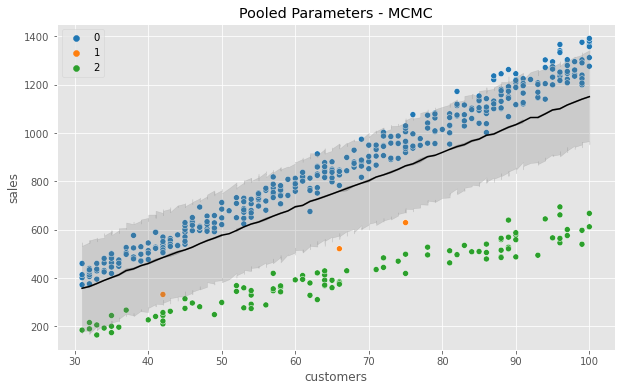

In [12]:
plt.figure(figsize=(10, 6))
sns.scatterplot(
    x=predictions['customers'], y=predictions['sales'], 
    hue=predictions['category'], palette='tab10')
sns.lineplot(
    x=predictions['customers'], y=predictions['sales_mu'],
    color='black')
plt.fill_between(
    x=predictions['customers'], 
    y1=predictions['sales_low'], 
    y2=predictions['sales_high'],
    color='grey',
    alpha=0.25)
plt.title('Pooled Parameters - MCMC')
plt.show()

### Pooled - SVI

Using LaPlace Approximation doesn't make the most sense since. . .

`pooled_guide` learns `beta`, but does not learn `sigma`. This could be related to parameter initialization

In [177]:
def pooled_guide(customers, sales=None): 

    sigma_scale = pyro.param(
        'sigma_scale', 0.1 * torch.rand(1), constraint=constraints.positive
        )
    sigma = pyro.sample('sigma', dist.HalfNormal(sigma_scale))

    beta_loc = pyro.param('beta_loc', torch.tensor(1.))
    beta_scale = pyro.param(
        'beta_scale', 0.1 * torch.rand(1), constraint=constraints.positive)
    beta = pyro.sample('beta', dist.Normal(beta_loc, beta_scale))

In [ ]:
pyro.render_model(
    pooled_guide (customers, sales), render_params=True)

In [ ]:
auto_guide = pyro.infer.autoguide.AutoLaplaceApproximation(pooled_model)

pyro.render_model(
    auto_guide, (customers, sales), render_params=True)

In [ ]:
pyro.clear_param_store()

#adam_params = {'lr': 0.005, 'betas': (0.95, 0.99)}
adam_params = {'lr': 0.001}
optim = Adam(adam_params)
svi = SVI(pooled_model, auto_guide, optim, Trace_ELBO())

iter = 2000
elbo_loss = []
for i in range(iter):
    loss = svi.step(customers, sales)
    elbo_loss.append(loss)

plt.figure(figsize=(10, 3))
plt.plot(np.arange(1, iter+1), elbo_loss)
plt.ylabel('ELBO Loss')
plt.xlabel('Iterations')
plt.title(f'iter {len(elbo_loss)}, loss: {elbo_loss[-1]:.4f}')
plt.show()

In [171]:
predictive = Predictive(pooled_model, guide=auto_guide, num_samples=1000)
posterior_svi_samples = predictive(customers, None)

#sigma, beta = utils.summary(posterior_svi_samples)['sigma'], \
#    utils.summary(posterior_svi_samples)['beta']

In [172]:
sales_mu = posterior_svi_samples['y'].mean(axis=0)
sales_std = posterior_svi_samples['y'].std(axis=0)

predictions_svi = pd.DataFrame({
    'customers': customers,
    'category': food_category,
    'sales': sales, 
    'sales_mu': sales_mu,
    'sales_std': sales_std,
    'sales_high': sales_mu + sales_std,
    'sales_low': sales_mu - sales_std
})

predictions_svi = predictions_svi.sort_values(by=['customers'])

In [ ]:
plt.figure(figsize=(10, 6))
sns.scatterplot(
    x=predictions_svi['customers'], y=predictions_svi['sales'], 
    hue=predictions_svi['category'], palette='tab10')
sns.lineplot(
    x=predictions_svi['customers'], y=predictions_svi['sales_mu'],
    color='black')
plt.fill_between(
    x=predictions_svi['customers'], 
    y1=predictions_svi['sales_low'], 
    y2=predictions_svi['sales_high'],
    color='grey',
    alpha=0.25)
plt.title('Pooled Parameters - SVI')
plt.show()

### Mixing Group and Common Parameters

In [190]:
def pooled_sigma_model(food_cat, customers, sales=None):

    P = len(np.unique(food_cat))
    N = len(customers)

    with pyro.plate('food_cat_i', P):
        beta = pyro.sample('beta', dist.Normal(10., 20.))
    
    sigma = pyro.sample('sigma', dist.HalfNormal(20.))

    with pyro.plate('data', N):
        mu = pyro.deterministic('mu', beta[food_cat] * customers)
        output = pyro.sample('y', dist.Normal(mu, sigma), obs=sales)

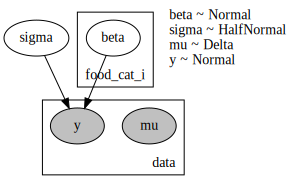

In [191]:
pyro.render_model(
    pooled_sigma_model, (food_category, customers, sales),
    render_distributions=True
)

In [192]:
kernel = NUTS(pooled_sigma_model)
mcmc_pooled_sigma = MCMC(kernel, 500, 300)
mcmc_pooled_sigma.run(food_category, customers, sales)

Sample: 100%|██████████| 800/800 [00:08, 94.70it/s, step size=8.38e-01, acc. prob=0.881] 


In [200]:
mcmc_pooled_sigma.summary()


                mean       std    median      5.0%     95.0%     n_eff     r_hat
   beta[0]     13.02      0.03     13.02     12.97     13.07    750.80      1.00
   beta[1]      8.14      0.38      8.14      7.49      8.72    428.68      1.00
   beta[2]      6.11      0.06      6.12      6.02      6.21    370.32      1.00
     sigma     39.25      1.34     39.12     37.09     41.32    387.78      1.00

Number of divergences: 0


In [194]:
pooled_sigma_samples = mcmc_pooled_sigma.get_samples(1000)
pooled_sigma_predictive = Predictive(pooled_sigma_model, pooled_sigma_samples)(food_category, customers, None)
az_pooled_sigma_inf = az.from_pyro(
    posterior=mcmc_pooled_sigma, posterior_predictive=pooled_sigma_predictive)

/Users/wastechs/opt/anaconda3/envs/probs/lib/python3.8/site-packages/arviz/data/io_pyro.py:157: UserWarning: Could not get vectorized trace, log_likelihood group will be omitted. Check your model vectorization or set log_likelihood=False
  warnings.warn(
posterior predictive shape not compatible with number of chains and draws.This can mean that some draws or even whole chains are not represented.
posterior predictive shape not compatible with number of chains and draws.This can mean that some draws or even whole chains are not represented.


/Users/wastechs/opt/anaconda3/envs/probs/lib/python3.8/site-packages/arviz/plots/hdiplot.py:157: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdi_data = hdi(y, hdi_prob=hdi_prob, circular=circular, multimodal=False, **hdi_kwargs)
/Users/wastechs/opt/anaconda3/envs/probs/lib/python3.8/site-packages/arviz/plots/hdiplot.py:157: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdi_data = hdi(y, hdi_prob=hdi_prob, circular=circular, multimodal=False, **hdi_kwargs)
/Users/wastechs/opt/anaconda3/envs/probs/lib/python3.8/site-packages/arviz/plots/hdiplot.py:157: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdi_data = hdi(y, hdi_prob=hdi_prob, circular=circula

Text(0.5, 1.0, 'Pooled Sigma')

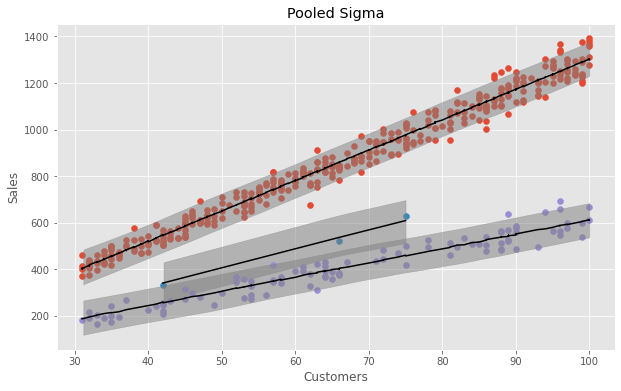

In [264]:
sales_df['food_cat_encode'] = food_category

fig, ax = plt.subplots(figsize=(10, 6))
az_pooled_sigma_inf['posterior']['sigma'].mean().values

for i in range(3):
    category_mask = sales_df['food_cat_encode'] == i
    mu_cat = pooled_sigma_predictive['y'][:, category_mask].mean(axis=0)

    customers = sales_df.loc[category_mask, ['customers']].values.flatten()
    sales = sales_df.loc[category_mask, ['sales']].values.flatten()

    ax.plot(customers, mu_cat, c='black')
    ax.scatter(customers, sales)
    az.plot_hdi(
        x=customers,
        y=pooled_sigma_predictive['y'][:, category_mask],
        color='grey'
    )
    
ax.set_xlabel('Customers')
ax.set_ylabel('Sales')
ax.set_title('Pooled Sigma')

## Hierarchical Models